# Computational Vision (90539) - Final Project

##### Authors
- Matteo Ghirardelli (4147398)
- Federico Minutoli (4211286)

##### Paper
J. Lu et al., *Knowing when to Look: Adaptive Attention via a Visual Sentinel for Image Captioning*, 2017

##### What will you see?
In this notebook we will present a series of experiments and visual plots on our PyTorch implementation of the aforementioned *adaptive attention-based* **Image captioning** model.

**Please note:** This notebook cannot be reproduced unless every COCO's folder is moved into the right place. Being over 5GB it is impossible to share those over with the notebook, as well. Feel free to ask, if you need them.

**Refer to our report for any reasoning on the main results that we will observe from the below experiments.**

In [13]:
!rm -rf sample_data

# Track cells runtime
!pip install ipython-autotime
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=82a1e6b5bc0d8f5f57c496ec6899de4e608e3117ab5645a37c754408288c35cf
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


Move data from personal Google Drive

In [ ]:
!unzip /content/drive/My\ Drive/preprocessing.zip -d ./

# Move folders up one level
!mv /content/content/* ./
!rm -rf /content/content

# Load pre-trained model
!cp /content/drive/My\ Drive/adaptive-25.pt ./

# Load evaluation scores
!cp /content/drive/My\ Drive/eval_scores.pkl ./
!cp /content/drive/My\ Drive/metrics_results-25.pkl ./
!cp /content/drive/My\ Drive/rank_vg_probs.pkl ./

# Load Python modules
!cp /content/drive/My\ Drive/build_vocab.py ./
!cp /content/drive/My\ Drive/data_loaders.py ./
!cp /content/drive/My\ Drive/models.py ./
!cp /content/drive/My\ Drive/utils.py ./

# Make a results directory
!mkdir results

Streaming output truncated to the last 5000 lines.
  inflating: ./content/data/resized/train2014/COCO_train2014_000000057708.jpg  
  inflating: ./content/data/resized/train2014/COCO_train2014_000000351627.jpg  
  inflating: ./content/data/resized/train2014/COCO_train2014_000000218644.jpg  
  inflating: ./content/data/resized/train2014/COCO_train2014_000000530403.jpg  
  inflating: ./content/data/resized/train2014/COCO_train2014_000000210416.jpg  
  inflating: ./content/data/resized/train2014/COCO_train2014_000000457791.jpg  
  inflating: ./content/data/resized/train2014/COCO_train2014_000000229472.jpg  
  inflating: ./content/data/resized/train2014/COCO_train2014_000000432686.jpg  
  inflating: ./content/data/resized/train2014/COCO_train2014_000000393480.jpg  
  inflating: ./content/data/resized/train2014/COCO_train2014_000000081107.jpg  
  inflating: ./content/data/resized/train2014/COCO_train2014_000000119854.jpg  
  inflating: ./content/data/resized/train2014/COCO_train2014_00000035

In [1]:
# Python libraries
import pickle
import torch
import json

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import skimage.transform

from torch.autograd import Variable 
from torchvision import transforms

from PIL import Image

# COCO libraries
from coco.pycocotools.coco import COCO
from coco.pycocoevalcap.eval import COCOEvalCap

# Local libraries
from build_vocab import Vocabulary
from data_loaders import CocoEvalLoader
from models import Encoder2Decoder

## Utility functions

In [2]:
def load_pkl(path):
    """Load a generic serialized binary file
    
    Parameters
    ----------
    path : str
        Path to a binary file
        
    Returns
    -------
    obj : Object
        Generic deserialized object
    """

    with open(path, 'rb') as f:
        obj = pickle.load(f)

    return obj

In [3]:
def load_model(pt_path, cpu=False):
    """Load model binary file

    Parameters
    ----------
    pt_path : str
        Path to the model binary in .pt format

    cpu : bool [False]
        Whether to load model to CPU
        
    Returns
    -------
    model : Encoder2Decoder
        Whole architecture object
    """

    if not cpu:
        model = torch.load(pt_path)
    else:
        model = torch.load(pt_path, map_location
                           =torch.device('cpu'))

    return model

In [4]:
def load_vocab(vocab_path='data/vocab.pkl'):
    """Load vocabulary binary file
    
    Parameters
    ----------
    vocab_path : str [data/vocab.pkl]
        Path to the vocabulary binary
        
    Returns
    -------
    vocab : Vocabulary
        Vocabulary wrapper object
    """

    vocab = load_pkl(vocab_path)
    return vocab

In [5]:
from math import ceil

def takespread(sequence, N):
    """Draw up to N equally-spaced elements from a sequence"""
    _len = float(len(sequence))

    for i in range(N):
        yield sequence[int(ceil(i * _len / N))]

## Training results

Show some important results from the training phase COCO's training dataset, which was run on CERN's HTCondor cluster for ~60 hours.

### SPICE validation scores epoch-by-epoch until 25th epoch

Refer to its original paper for more in-depth details on the SPICE metric itself and why it has shown to better mimic human judgement than all the previous metrics that come from machine translation (BLEU, METEOR, CIDEr).
https://arxiv.org/abs/1607.08822

As you will observe, the SPICE metric score is much lower than any of the others, but this is expected behaviour as it is a very strict metric on the goodness of the generated captions. At the same time, being so low has pushed Image captioning models to seek new heights.

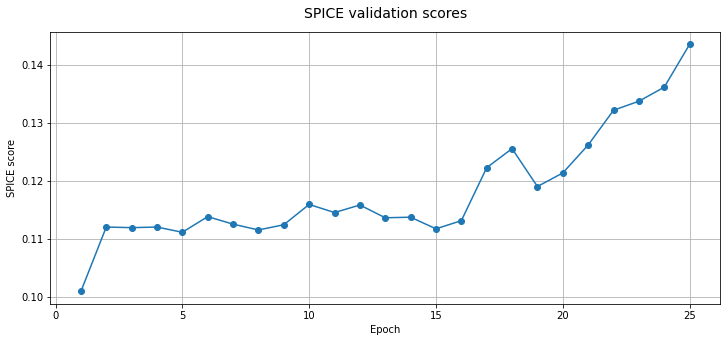

In [ ]:
spice_eval_scores = load_pkl('eval_scores.pkl')[17] # That file was generated from epoch 17 despite
                                                    # having all the previous SPICE scores
# Go from 1 to len(spice_eval_scores)                                                    
epochs = np.arange(len(spice_eval_scores)) + 1

plt.figure(figsize = (12, 5))
plt.title("SPICE validation scores",
          size = 14, pad = 14)
plt.plot(epochs, spice_eval_scores, '-o')
plt.ylabel('SPICE score')
plt.xlabel('Epoch')
plt.grid()
plt.savefig('spice_eval_scores.jpg')
plt.show()

Make a table for all evaluation metrics at epoch 25: BLEU-n, CIDEr, METEOR, SPICE, ROUGE-L and WMD.

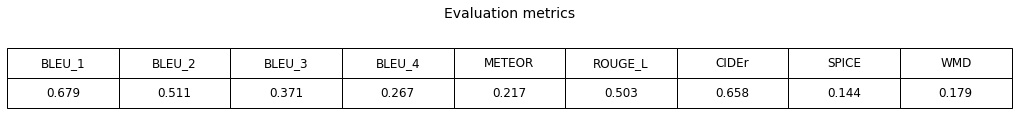

time: 341 ms


In [26]:
metrics_scores = load_pkl('metrics_results-25.pkl') # Scores on all the main evaluation metrics

# Table columns
cols = list(metrics_scores.keys())
cols = list(map(lambda x: x.upper() if x
                .startswith('Bleu') else x, cols))

# Table rows
data = [
        list(map(lambda x: '%.3f' % x,
                 metrics_scores.values()))
]

plt.figure(figsize = (18, 2))
plt.axis('tight')
plt.axis('off')
plt.title('Evaluation metrics', size = 14)

table = plt.table(cellText=data, colLabels=cols, loc='center', cellLoc='center')
table.set_fontsize(12)
table.scale(1, 2.5)

plt.savefig('eval_metrics.jpg')
plt.show()

As you can see, our implementation of ***KwtL*** model performs considerably worse than the original one from the authors. We've addressed a few reasons on why that's the case in the report, which we'll briefly list here, as well:

- No teacher forcing in KwtL training
- No beam search in KwtL evaluation
- Different tokenizer: Stanford PTB vs NLTK package
- Much lower number of epochs: 25 vs 50

### Rank of tokens by visual grounding probabilities

Visual grounding probabilities represent the likelihood of a given word to be considered to describe an image region at any given time prior to any attention-based influx both from visual features $V$ and the sentinel $s_t$.

Mathematically, it's computed from the sentinel gate value $\beta$:
$$
    p_{vg} = 1 - \beta
$$

In our case, we computed the average visual grounding probability for each word during training on the COCO dataset, by summing their visual grounding probabilities across the different generated captions they were in, over the occurance they had within them. In this sense, we would expect conjunctions, attributes and common adjectives to be at the very bottom of the distribution, as they would be the most frequent terms, without providing a concrete understanding of the visual content.

We are truncating `vg_probabilities` to the take 20 equally-spaced entries to match what the authors did in the paper, as they ranked in Fig. 6 20 words from the vocabulary along the visual grounding probability distribution. In fact, we will take only 19 entries + `<unk>` token, that is, a special token that was implied to signal a non-recognized word w.r.t. the vocabulary. 

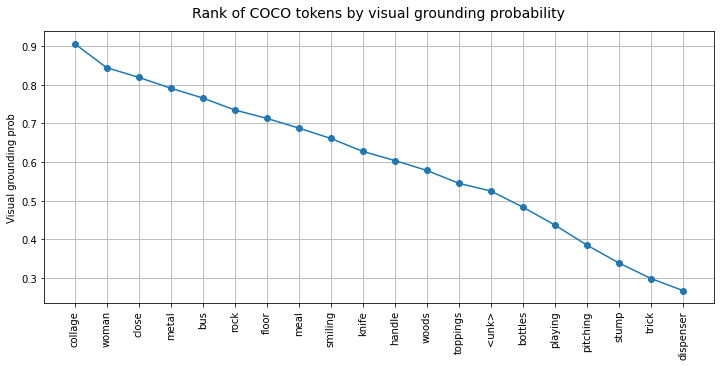

In [ ]:
# Note: Visual grounding probabilities are already sorted in the binary file,
# so by taken them equally-spaced makes sense to navigate through the distribution
vg_probabilities = load_pkl('rank_vg_probs.pkl')

# Take 19 entries + <unk> token
vg_probabilities = sorted(list(takespread(vg_probabilities, 19)) \
                            + list(filter(lambda x : x[0] == '<unk>',
                                          vg_probabilities)), key = lambda x: x[1], reverse=True)

# Unzip words from probabilities
words, vg_probs = zip(*vg_probabilities)

plt.figure(figsize = (12, 5))
plt.title("Rank of COCO tokens by visual grounding probability",
          size = 14, pad = 14)
plt.plot(words, vg_probs, '-o')
plt.ylabel('Visual grounding prob')
plt.xticks(rotation='vertical')
plt.grid()
plt.savefig('rank_vg_probs.jpg')
plt.show()

Now we will also take the exact 23 words they used in Fig. 6, to see how the two fend off w.r.t. each other.

In [ ]:
paper_words = [
    'dishes', 'people', 'cat', 'giraffe',
    'boat', 'three', 'table', 'kite',
    'crossing', 'sign', 'cell', 'during',
    'cross', 'the', '<unk>', 'his',
    'from', 'of', 'phone', 'it',
    'to', 'edge', 'crossed'
]

Found matching tokens: 18 



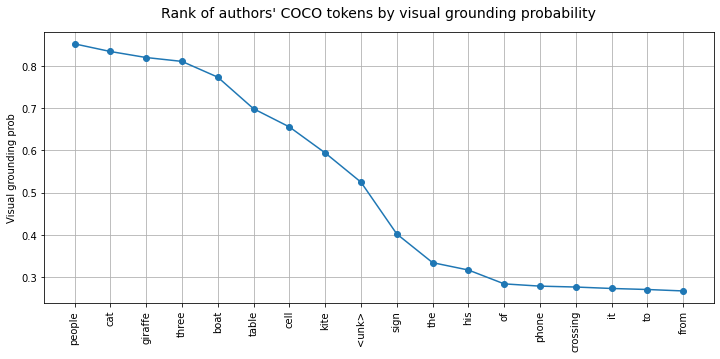

In [ ]:
vg_probabilities = load_pkl('rank_vg_probs.pkl')

# Take the paper's 20 entries (<unk> included)
vg_probabilities = sorted(list(filter(lambda x : x[0] in paper_words,
                                      vg_probabilities)), key = lambda x: x[1], reverse=True)

print('Found matching tokens:',
      len(vg_probabilities), '\n')

# Unzip words from probabilities
words, vg_probs = zip(*vg_probabilities)

plt.figure(figsize = (12, 5))
plt.title("Rank of authors' COCO tokens by visual grounding probability",
          size = 14, pad = 14)
plt.plot(words, vg_probs, '-o')
plt.ylabel('Visual grounding prob')
plt.xticks(rotation='vertical')
plt.grid()
plt.savefig('rank_vg_probs_paper.jpg')
plt.show()

## Visualize experiments on COCO

Here on we will test our model against Karpathy's test split of COCO's dataset in order to compare the evaluation metrics scores against what we gathered above form the training phase on COCO. Also, we will draw 10 random images to visualize their attention map with, word-by-word for a qualitative evaluation of our model's capabilities on images that it has never seen before.

Afterwards, we will evaluate the same Karpathy's split with NeuralTalk 2 API hosted on DeepAI [website](https://deepai.org/machine-learning-model/neuraltalk) to compare the two models according to all the illustrated metrics, since NT 2 has seen a lot of success in recent years.

**Note:** You can use the below function `visualize_vg_att` to test the pre-trained **KwtL** model on a new image of your choice, granted that you've loaded the model and the vocabulary before-hand. Feel free to try it out.

In [9]:
def visualize_vg_att(model, vocab, image_path,
                     smooth = True, crop_size = 224):
    """
    Visualize the attention map of every word in the generated caption and their visual grounding probabilities.
    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb

    Parameters
    ----------
    model : Encoder2Decoder
        Pre-trained KwtL model

    vocab : Vocabulary
        Vocabulary wrapper object

    image_path : str
        Path to COCO images root directory

    smooth : bool [True]
        Whether to pyramidal expand attention weights into an attention map of 224x224
    
    crop_size : int
        Size to crop COCO images to
    """

    # Import libraries
    from utils import to_var

    model.eval() # Set to evaluation mode
    
    trans = transforms.Compose([ 
        transforms.Scale((crop_size, crop_size)),
        transforms.ToTensor()])
    
    trans_normalize = transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))
    
    # Keep b without normalization for display purposes,
    # whereas img will be used to feed the Enc2Dec sampler with
    b = Image.open(image_path).convert('RGB') # Discard alpha channel, if present
    b = trans(b)
    
    img = trans_normalize(b).unsqueeze(0) # 1 x 3 x H x W
    img = to_var(img) 

    generated_captions, alphas, betas = model.sampler(img)

    # Dummy image index to refer to, since we are dealing
    # with only one image at the time
    img_idx = 0

    # Transform captions into a NumPy vector to easier
    # deal with the following computation
    if torch.cuda.is_available():
        captions = generated_captions.cpu().data.numpy()
    else:
        captions = generated_captions.data.numpy()

    sampled_ids = captions[img_idx]
    vg_prob_att_caption = [] # List of triplets: (word, attention weight, visual grounding prob)
    
    # For every word within the caption
    for j, word_id in enumerate(sampled_ids):
        word = vocab.idx2word[word_id]

        # Exit from the loop on the <end> token, since all the remaining ones
        # would be <pad> tokens artificially inflated, if needed, to make
        # captions of the very same length (i.e., 20)
        if word == '<end>':
            break
        else:
            vg_prob_att_caption.append((word, alphas[img_idx][j], 1.
                                        - betas[img_idx][j])) # Visual grounding prob := 1 - beta

    plt.figure(figsize = (20, 10))
        
    # Spatial attention plots
    for t in range(len(vg_prob_att_caption)): # For every time step t
        plt.subplot(np.ceil(len(vg_prob_att_caption) / 5.), 5, t + 1)
        plt.text(0, 1, '%s - [%.3f]' % (vg_prob_att_caption[t][0], vg_prob_att_caption[t][2]), color = 'black',
                               backgroundcolor = 'white', fontsize = 12)
    
        plt.imshow(transforms.ToPILImage()(b.cpu()))

        alpha = vg_prob_att_caption[t][1]

        # Expand attention map to 224x224
        if smooth:
            alpha = skimage.transform.pyramid_expand(alpha.cpu().detach().numpy().reshape(7, 7),
                                                     upscale = 32, sigma = 8)
        else:
            alpha = skimage.transform.resize(alpha.cpu().detach().numpy().reshape(7, 7), [7 * 32, 7 * 32]) # 224 = 7 * 32

        if t == 0:
            plt.imshow(alpha, alpha = 0) # Show original image on <start>
        else:
            plt.imshow(alpha, alpha = 0.8)

        plt.set_cmap(cm.Greys_r)
        plt.axis('off')

    # Flush attention plots
    plt.subplots_adjust(wspace=0.3, hspace=0.05)
    plt.show()

In [7]:
def evaluate_results(ann_path, results, is_kwtl=True):
    """Evaluate ground-truth COCO captions vs generated ones

    Parameters
    ----------
    ann_path : str
        Path to COCO annotation file

    results : list
        List of dictionaries {image_id, caption}

    is_kwtl : bool [True]
        Whether it's being called by KwtL or NT 2 API

    Returns
    -------
    metrics_results : dict
        Evaluation scores for the major metrics
    """
    # Note: `coco.loadRes()` from COCO's API requires a file path as input to load the generated captions.
    # That's why we need to first save the resulting list of captions to a JSON file and only then load it from the COCO object.
    # This of course slows the evaluation down a bit (as any I/O operation), but there's no way around it.

    # Evaluate the results based on COCO's API
    if is_kwtl:
        res_file = 'results/mixed-test.json'
    else:
        res_file = 'results/mixed-test-nt2.json'

    json.dump(results, open(res_file , 'w'))
    
    coco = COCO(ann_path)
    coco_res = coco.loadRes(res_file)
    
    coco_eval = COCOEvalCap(coco, coco_res)
    coco_eval.params['image_id'] = coco_res.getImgIds() # Filter out images we haven't generated a caption for
    coco_eval.evaluate()
    
    # Get scores for validation evaluation with a focus on SPICE
    metrics_results = {}

    print('-----------Evaluation performance on MS-COCO test dataset')
    for metric, score in coco_eval.eval.items():
        metrics_results[metric] = score

    return metrics_results

In [8]:
def coco_test(model, vocab, args, visualize=True):
    """Evaluate the KwtL adaptive model on MS COCO test split
    
    Parameters
    ----------
    model : models.Encoder2Decoder
        KwtL adaptive model after the given epoch

    vocab : build_vocab.Vocabulary
        Vocabulary object
        
    args : dict
        Dictionary of arguments
        (i.e., crop_size, vocab_path, etc...)

    visualize : bool [True]
        Whether to visualize 10 random images from COCO
        
    Returns
    -------
    metrics_results : dict
        Dictionary of per-metric scores
        (i.e., CIDEr, BLEU, SPICE, etc...)
    """
    # Import necessary libraries
    import os

    from utils import to_var

    # Set the model to evaluation mode to avoid
    # the backpropagation of gradients
    model.eval()
    
    # Sequence of transforms to apply to images:
    #   1. Crop to 224x224 (args.crop_size)
    #
    #   2. Return as a Torch tensor
    #
    #   3. Normalize RGB channels using mean and std from ImageNet. This is a standard practice utilized within PyTorch environment,
    #      since ImageNet comprises of millions of images and computing the mean and the standard deviation
    #      among all those images is much more reliable than doing it from scratch.
    trans_total = transforms.Compose([ 
        transforms.Scale((args['crop_size'], args['crop_size'])),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # COCO test data loader.
    test_data_loader = torch.utils.data.DataLoader( 
        CocoEvalLoader(args['image_dir'],
                       args['caption_test_path'], trans_total), 
        batch_size=args['batch_size'], num_workers=args['num_workers'],
        shuffle=False, drop_last=False
    )  
    
    # Generated captions to be compared with ground-truth
    # (i.e., {'image_id': <image_id>, 'caption': <caption>})
    results = []

    # Paths of images to visualize
    file_paths = []

    print('---------------------Start test on MS-COCO dataset-----------------------')
    for i, (images, image_ids, filenames) in enumerate(test_data_loader):
        # Generate captions with KwtL
        images = to_var(images) # Wrap images in a Variable.
        generated_captions, _, _ = model.sampler(images)
        
        # If CUDA is available, the below tensors are in GPU. If that's the case, move them to CPU (with `.cpu()`)
        # before transforming them to NumPy arrays, because CUDA cannot talk to NumPy's processor.
        if torch.cuda.is_available():
            captions = generated_captions.cpu().data.numpy()
        else:
            captions = generated_captions.data.numpy()

        # Build captions based on vocabulary since captions contains the indexes of words from the vocabulary,
        # but not the words themselves. So, to have something readable, they have to be converted using
        # the vocabulary's mapping, while skipping the <end> token.
        for image_idx in range(captions.shape[0]): # For every image in the batch
            sampled_ids = captions[image_idx]
            sampled_caption = []
            
            for j, word_id in enumerate(sampled_ids): # For every word index in the caption
                word = vocab.idx2word[word_id]

                if word == '<end>': # Skip the <end> token and break
                    break
                else:
                    sampled_caption.append(word)

            sentence = ' '.join( sampled_caption )
            
            # image_idx : Image index within the current batch
            # image_id  : Unique image ID within COCO's dataset
            temp = {
                'image_id': int(image_ids[image_idx]),
                'caption': sentence
            }
            results.append(temp)
        
        # Display evaluation process every 30 batches
        if (i + 1) % 30 == 0:
            print('[%d/%d]'%((i + 1), len(test_data_loader)))

            # Choose a random image from the batch
            filename = filenames[torch.randint(len(filenames), (1,))]

            if 'val' in filename.lower():
                path = os.path.join(args['image_dir'], 'val2014', filename)
            else:
                path = os.path.join(args['image_dir'], 'train2014', filename)

            file_paths.append(path)
            
    print('------------------------Captions generated------------------------------------')
    metrics_results = evaluate_results(args['caption_test_path'],
                                       results, True)

    if visualize:
        for path in file_paths:
            visualize_vg_att(model, vocab, path)
            print('\n\n') # Vertical spacing
            print('==============================================================================')
            print('\n\n')
            
    return metrics_results

Load the vocabulary and the Enc2Dec model

In [10]:
# Load the Vocabulary object
vocab = load_vocab()

# Load the Enc2Dec model object
model = load_model('adaptive-25.pt') # add cpu=True if on a CPU-only machine
model.eval() # Evaluation mode

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'models.Encoder2Decoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'models.AttentiveCNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'models.Decoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and 

Encoder2Decoder(
  (encoder): AttentiveCNN(
    (resnet_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace

In [11]:
# Same argumetns as what we used
# to train the model on COCO
args = {
    'batch_size': 16,
    'caption_test_path': 'data/annotations/karpathy_split_test.json',
    'crop_size': 224,
    'image_dir': 'data/resized',
    'num_workers': 4
}

Evaluate the **KwtL** model on Karpathy's test split

**Note:** Please open it in Colab to view captions with attention maps.

In [14]:
# Avoid CUDA out of memory
import gc
gc.collect()

kwtl_metrics_scores = coco_test(model, vocab, args)

Output hidden; open in https://colab.research.google.com to view.

## Comparison against *NeuralTalk2* API

In [22]:
def coco_test_nt2(args):
    """Evaluate the KwtL adaptive model on MS COCO test split
    
    Parameters
    ----------
    args : dict
        Dictionary of arguments
        (i.e., crop_size, vocab_path, etc...)
        
    Returns
    -------
    metrics_results : dict
        Dictionary of per-metric scores
        (i.e., CIDEr, BLEU, SPICE, etc...)
    """
    # Import necessary libraries
    import os
    import requests

    from utils import to_var

    trans_total = transforms.Compose([ 
        transforms.Scale((args['crop_size'], args['crop_size'])),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # COCO test data loader.
    test_data_loader = torch.utils.data.DataLoader( 
        CocoEvalLoader(args['image_dir'],
                       args['caption_test_path'], trans_total), 
        batch_size=args['batch_size'], num_workers=args['num_workers'],
        shuffle=False, drop_last=False
    )  
    
    # Generated captions to be compared with ground-truth
    # (i.e., {'image_id': <image_id>, 'caption': <caption>})
    results = []

    print('---------------------Start test with NT 2 API-----------------------')
    for i, (_, image_ids, filenames) in enumerate(test_data_loader):
        for idx, filename in enumerate(filenames):
            if 'val' in filename.lower():
                path = os.path.join(args['image_dir'], 'val2014', filename)
            else:
                path = os.path.join(args['image_dir'], 'train2014', filename)

            # Make a request to NT 2 API
            r = requests.post("https://api.deepai.org/api/neuraltalk",
                files = {
                    'image': open(path, 'rb'),
                },
                headers = {
                    'api-key': 'a213adc1-d552-4a85-87e6-6f900825285d' # Personal API key after signing up on Deep AI
                }
            )
            caption = r.json()['output']

            temp = {
                'image_id': int(image_ids[idx]),
                'caption': caption
            }
            results.append(temp)

        # Display evaluation process every 30 batches
        if (i + 1) % 30 == 0:
            print('[%d/%d]'%((i + 1), len(test_data_loader)))
            
    print('------------------------Captions generated------------------------------------')

    return evaluate_results(args['caption_test_path'],
                            results, False)

time: 30.9 ms


**Note:** The following cell may take up to an 2 hours, as it has to make 5000 API calls to Deep AI's website.

In [23]:
nt2_metrics_scores = coco_test_nt2(args)

---------------------Start test with NT 2 API-----------------------


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:211: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


[30/313]
[60/313]
[90/313]
[120/313]
[150/313]
[180/313]
[210/313]
[240/313]
[270/313]
[300/313]
------------------------Captions generated------------------------------------
loading annotations into memory...
0:00:00.052764
creating index...
index created!
Loading and preparing results...     
DONE (t=0.01s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 44596, 'reflen': 45333, 'guess': [44596, 39596, 34596, 29596], 'correct': [33850, 18777, 9359, 4626]}
ratio: 0.9837425275185631
Bleu_1: 0.747
Bleu_2: 0.590
Bleu_3: 0.453
Bleu_4: 0.345
computing METEOR score...
METEOR: 0.260
computing Rouge score...
ROUGE_L: 0.555
computing CIDEr score...
CIDEr: 1.058
-----------Evaluation performance on MS-COCO test dataset
time: 1h 57min 28s


Sumarize  KwtL and NT's evaluation scores in a table.

**Note:** Unfortunately both SPICE and Google's WMD scorers rely on custom models that are called behind the scenes within Java's suite by command line's dedicated commands (see spice.py and wmd.py in coco.pycocoevalcap). Probably we should try to install a different Java version (8?) here in Colab but we'll try this experiment for later on. Hence, the table below will lack those scores.

Also, to make it work one has to comment line 50 and 51 (SPICE and WMD) from the scores within coco.pycocoevalcap.eval, which is of course not ideal to reproduce since those files directly come from COCO's API.

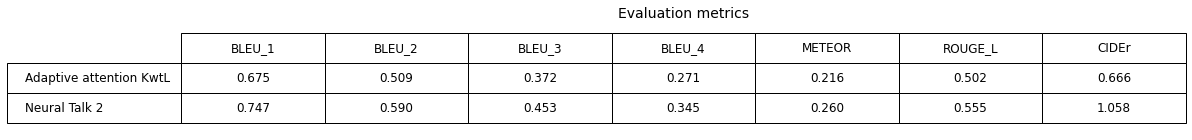

time: 459 ms


In [25]:
# Table columns (equal for both)
cols = list(nt2_metrics_scores.keys()) 
cols = list(map(lambda x: x.upper() if x
                .startswith('Bleu') else x, cols))

# Table rows
data = [
        list(map(lambda x: '%.3f' % x,
                 kwtl_metrics_scores.values())),
        list(map(lambda x: '%.3f' % x,
                 nt2_metrics_scores.values())),
]

plt.figure(figsize = (18, 2))
plt.axis('tight')
plt.axis('off')
plt.title('Evaluation metrics', size = 14)

table = plt.table(cellText=data, colLabels=cols,
                  rowLabels=['Adaptive attention KwtL', 'Neural Talk 2'],
                             loc='center', cellLoc='center')
table.set_fontsize(12)
table.scale(1, 2.5)

plt.savefig('eval_metrics_test.jpg')
plt.show()

## Android porting results

Have a look at the attached MP4 video with a demo of our model run in pseudo-real time on a Huawei P40 device. Refer to the report for every detail regarding the performances and substainability of the model on an Android device.

**Note:** At the current state we weren't able to port the model to Android because we would have needed a few more days. It's not complicated in theory as there is a Torch API designed for Android use, so we will still may try to test its behaviour on a considerably less powerful device like a mobile Android phone can be, before the oral session.